In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"
# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_0p50dh1w.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[100,100,100], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


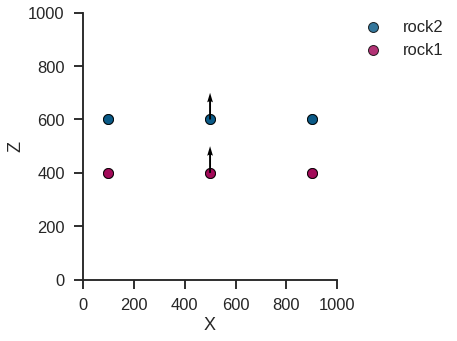

In [3]:
gp.plot.plot_data(geo_data)

In [4]:
dz = geo_data.grid.regular_grid.dz
dz

10.0

In [5]:
geo_data.surfaces.add_surfaces_values([0, 5, 0])

,surface,series,order_surfaces,isBasement,color,id,value_0
0,rock2,Default series,1,False,#015482,1,0
1,rock1,Default series,2,False,#9f0052,2,5
2,basement,Basement,1,True,#ffbe00,3,0


In [6]:
geo_data.interpolator.theano_graph.block_matrix.dtype

'float32'

In [7]:

import theano
theano.config.floatX

'float32'

In [8]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile', gradient=False)

Compiling theano function...
Compilation Done!


In [9]:
gp.compute_model(geo_data, compute_mesh=False)



Lithology ids 
  [3. 3. 3. ... 1. 1. 1.] 

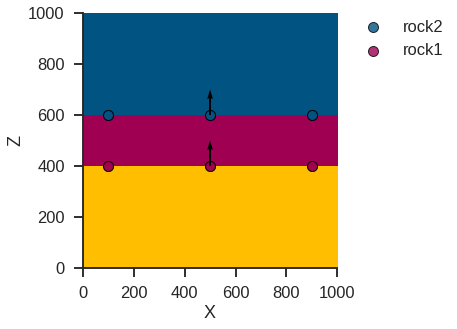

In [10]:
gp.compute_model(geo_data)
gp.plot.plot_section(geo_data, 1, show_data=True)

In [11]:
geo_data.interpolator.grid.values_r

array([[0.190725, 0.190725, 0.190725],
       [0.190725, 0.190725, 0.196975],
       [0.190725, 0.190725, 0.203225],
       ...,
       [0.809475, 0.809475, 0.796975],
       [0.809475, 0.809475, 0.803225],
       [0.809475, 0.809475, 0.809475]])

In [12]:
import theano
import theano.tensor as T

grid_sh = theano.shared(geo_data.interpolator.get_python_input_block()[6])

In [13]:
geo_data.interpolator.theano_graph.grid_val_T = grid_sh

In [14]:
geo_data.interpolator.theano_graph.grid_val_T

<GpuArrayType<None>(float32, matrix)>

In [15]:
th_f_2 = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                        geo_data.interpolator.theano_graph.compute_a_series(
    len_i_0=0, len_i_1=geo_data.interpolator.theano_graph.len_series_i[1],
    len_f_0=0, len_f_1=geo_data.interpolator.theano_graph.len_series_o[1],
    len_w_0=0, len_w_1=geo_data.interpolator.theano_graph.len_series_w[1],
    n_form_per_serie_0=0, n_form_per_serie_1=geo_data.interpolator.theano_graph.n_surfaces_per_series[1],
    u_grade_iter=3,
    compute_weight_ctr=np.array(True), compute_scalar_ctr=np.array(True), compute_block_ctr=np.array(True),
    is_finite=np.array(False), is_erosion=np.array(True), is_onlap=np.array(False),
    n_series=0,
    block_matrix=geo_data.interpolator.theano_graph.block_matrix,
    weights_vector=geo_data.interpolator.theano_graph.weights_vector,
    scalar_field_matrix=geo_data.interpolator.theano_graph.scalar_fields_matrix,
    sfai=geo_data.interpolator.theano_graph.sfai,
    mask_matrix=geo_data.interpolator.theano_graph.mask_matrix
                 ),
                         on_unused_input='ignore',
                        profile=True)

In [16]:
th_f_2(*geo_data.interpolator.get_python_input_block())[1]

array([-2.5706997e-13, -2.5706943e-13,  4.3016716e-13,  4.3016675e-13,
        1.0870253e-19,  2.4696043e-19, -1.6955084e-13, -1.4287715e-12,
        1.4287703e-12,  1.6955781e-13,  5.7818171e-13, -1.6955023e-13,
       -1.4287735e-12,  1.4287744e-12,  1.6954380e-13,  5.7819336e-13,
       -1.8235013e-10,  4.3459636e-10,  1.0000000e+00], dtype=float32)

In [17]:
th_f_2.profile.summary()

Function profiling
  Message: <ipython-input-15-461ec0441d66>:18
  Time in 1 calls to Function.__call__: 2.082896e-02s
  Time in Function.fn.__call__: 2.075076e-02s (99.625%)
  Time in thunks: 2.033544e-02s (97.631%)
  Total compile time: 8.350075e+00s
    Number of Apply nodes: 726
    Theano Optimizer time: 4.486688e+00s
       Theano validate time: 1.010261e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 3.522289e+00s
       Import time 5.219746e-02s
       Node make_thunk time 3.494467e+00s
           Node GpuElemwise{Composite{sqr((i0 * (i1 - (-i2))))}}[(0, 2)]<gpuarray>(GpuArrayConstant{[[[0.5]]]}, InplaceGpuDimShuffle{x,x,x}.0, InplaceGpuDimShuffle{x,x,x}.0) time 9.769561e-01s
           Node forall_inplace,gpu,Looping grid}(HostFromGpu(gpuarray).0, GpuSubtensor{int64:int64:int8}.0, GpuSubtensor{int64:int64:int8}.0, GpuIncSubtensor{InplaceSet;:int64:}.0, GpuJoin.0, InplaceGpuDimShuffle{1,0}.0, GpuElemwise{mul,no_inplace}.0, GpuSubtensor{int64:int32:}.0,

In [18]:
theano.config.allow_gc, theano.config.scan.allow_gc

(True, False)